In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 51.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 48.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


# 1. Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, SAGEConv
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import random
import networkx as nx
import tqdm
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

In [3]:
csv_file = "node_information.csv"
node_information = pd.read_csv(csv_file, header=None)
node_information.rename(columns={0: "node_id"}, inplace=True)
node_information.head()

,node_id,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
node_information = pd.read_csv('node_information.csv', header=None, index_col=0)
train_set = pd.read_csv('train.txt', header=None, sep=' ')
train_set.columns = ['node1', 'node2', 'connected']
test_set = pd.read_csv('test.txt', header=None, sep=' ')
test_set.columns = ['node1', 'node2']

mapping = {node_information.index[i]: i for i in range(len(node_information))}
node_information.index = node_information.index.map(mapping)
train_set["node1"] = train_set["node1"].map(mapping)
train_set["node2"] = train_set["node2"].map(mapping)
test_set["node1"] = test_set["node1"].map(mapping)
test_set["node2"] = test_set["node2"].map(mapping)

In [5]:
train_set

,node1,node2,connected
0,510,1991,1
1,1308,2872,1
2,100,1991,1
3,466,1221,1
4,723,2846,1
...,...,...,...
10491,44,3176,0
10492,1,3159,0
10493,1767,3272,1
10494,840,2385,0


In [6]:
# combien de samples positifs et négatifs
pos = len(train_set[train_set['connected'] == 1])
neg = len(train_set[train_set['connected'] == 0])
print(f"Positif: {pos}")
print(f"Negatif: {neg}")

Positif: 5248
Negatif: 5248


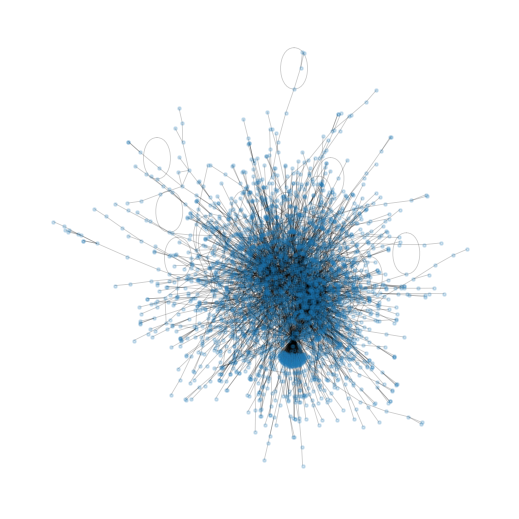

In [7]:
connected_edges = train_set[train_set['connected'] == 1]
training_graph = nx.from_pandas_edgelist(connected_edges, source='node1', target='node2', create_using=nx.Graph())
plt.figure(figsize=(5,5))

nx.draw(training_graph, node_size = 5, alpha = 0.2, width = 0.6)

plt.show()

In [8]:
# create test samples
test_samples = [tuple((element[0], element[1])) for element in test_set.values]
# create train and val samples
samples = list(zip(train_set['node1'], train_set['node2']))
labels = train_set['connected']
train_samples, val_samples, train_labels, val_labels = train_test_split(samples, labels, test_size=0.2, random_state=42)

# Afficher la taille des ensembles
print("Nombre d'échantillons d'entraînement :", len(train_samples))
print("Nombre d'échantillons de validation :", len(val_samples))

# Repartition des labels dans val et train
print("Nombre de labels positifs dans l'ensemble d'entraînement :", sum(train_labels))
print("Nombre de labels positifs dans l'ensemble de validation :", sum(val_labels))


Nombre d'échantillons d'entraînement : 8396
Nombre d'échantillons de validation : 2100
Nombre de labels positifs dans l'ensemble d'entraînement : 4207
Nombre de labels positifs dans l'ensemble de validation : 1041


In [9]:
def remove_val_edges(graph,val_samples):
    """
    Remove edges from validation set before computing
    """
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")

    residual_g = graph.copy()

    # Shuffle the list of edges
    edges = list(residual_g.edges())

    for (source, target) in val_samples:
        if residual_g.has_edge(source, target):
            residual_g.remove_edge(source, target)

    return residual_g

residual_g = remove_val_edges(training_graph, val_samples)

In [10]:
residual_edges = list(residual_g.edges())
assert len(residual_edges) == sum(train_labels)

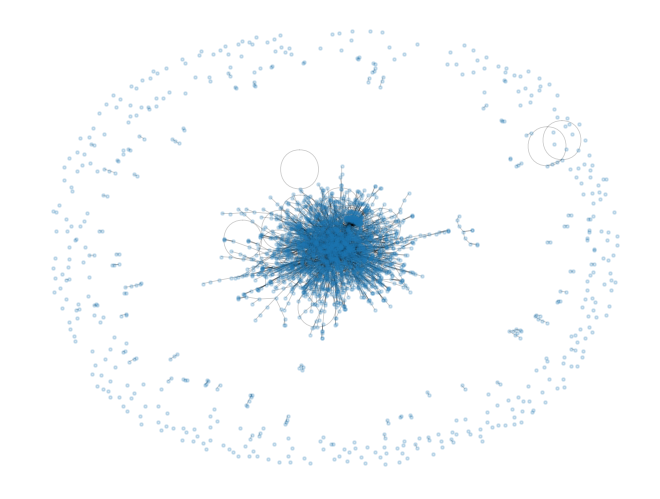

In [11]:
nx.draw(residual_g, node_size = 5, alpha = 0.2, width = 0.6)

In [12]:
def feature_extractor(graph, samples, node_information):
    """
    Creates a feature vector for each edge of the graph contained in samples
    """
    feature_edge_vector = []
    for edge in tqdm.tqdm(samples):
        source_node, target_node = edge[0], edge[1]
        # Preferential Attachement
        if source_node not in graph or target_node not in graph:
            pref_attach = 0
        else:
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        if source_node not in graph or target_node not in graph:
            aai = 0
        else:
            aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
            if np.isinf(aai):
                aai = 0
        # Compute the Jaccard coefficient
        if source_node not in graph or target_node not in graph:
            jacard_coeff = 0
        else:
            neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
            inter = len(neighbords_source.intersection(neighbord_target))
            union = len(neighbords_source.union(neighbord_target))
            if union == 0:
                jacard_coeff = 0
            else:
                jacard_coeff = inter/union

        # Create edge feature vector with all metric computed above
        feature_edge_vector.append(np.array([pref_attach, aai, jacard_coeff]) )
    return np.array(feature_edge_vector)

In [13]:
def add_degree_centrality_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  deg_centrality = nx.degree_centrality(residual_g)
  node_information['degree_centrality'] = 0
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Degree Centrality
      node_information.at[source_node, 'degree_centrality'] = deg_centrality[source_node]

      # Attribution de la centralité degré au nœud cible
      node_information.at[target_node, 'degree_centrality'] = deg_centrality[target_node]
  return node_information


In [14]:
node_information = add_degree_centrality_to_features(residual_g,train_samples, val_samples,test_samples, node_information)


100%|██████████| 13994/13994 [00:00<00:00, 28686.82it/s]


In [15]:
# --- Create feature vector for all edges in training set and val set ---
train_features = feature_extractor(residual_g, train_samples, node_information)
val_features = feature_extractor(residual_g, val_samples, node_information)
test_features = feature_extractor(training_graph, test_samples, node_information)

  0%|          | 0/8396 [00:00<?, ?it/s]<ipython-input-12-e587a879a9ad>:18: RuntimeWarning: divide by zero encountered in scalar divide
  aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
100%|██████████| 3498/3498 [00:00<00:00, 39774.54it/s]


# 2. Create Train, Val and Test Dataset

In [16]:
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader

In [17]:
x = torch.tensor(node_information.values, dtype=torch.float)

# Convert labels to PyTorch tensor
y_train = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in train_labels], dtype=torch.long)
y_val = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in val_labels], dtype=torch.long)

# Convert edge indices to PyTorch tensor
edge_index_train = torch.tensor(train_samples,dtype=torch.long).transpose(0, 1)
edge_index_val = torch.tensor(val_samples, dtype=torch.long).transpose(0,1)
edge_index_test = torch.tensor(test_samples, dtype=torch.long).transpose(0,1)

# create edge features
edge_attr_train = torch.tensor(train_features, dtype=torch.float)
edge_attr_val = torch.tensor(val_features, dtype=torch.float)
edge_attr_test = torch.tensor(test_features, dtype=torch.float)


In [18]:
# Create Data objects for train and validation sets
data_train = Data(x=x, edge_index=edge_index_train , edge_attr= edge_attr_train,y=y_train)
data_val = Data(x=x, edge_index=edge_index_val, edge_attr = edge_attr_val ,y=y_val)

# # create dataloader for train et val
batch_size = 32
train_data_loader = NeighborLoader(data_train, num_neighbors=[-1], batch_size=batch_size, shuffle=True)
val_data_loader = NeighborLoader(data_val, num_neighbors=[-1], batch_size=batch_size, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


# 3. Model Definition

In [19]:
from torch_geometric.nn import GCNConv
class GATModel(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_size_bis, output_size_embed, nb_edge_features):
    super().__init__()
    # self.conv1 = GATv2Conv(input_size, hidden_size, heads=6)
    # self.conv2 = GATv2Conv(6 * hidden_size, hidden_size, heads=4)
    # self.conv3 = GATv2Conv(4 * hidden_size, hidden_size_bis, heads=4)
    # self.conv4 = GATv2Conv(4 * hidden_size_bis, output_size_embed, heads=6, concat=False)

    # self.conv1 = SAGEConv(input_size, hidden_size, aggr="max")
    # self.conv2 = SAGEConv(hidden_size, hidden_size_bis, aggr="mean")
    # self.conv3 = SAGEConv(hidden_size_bis, hidden_size_bis//2, aggr="max")
    # self.conv4 = SAGEConv(hidden_size_bis//2, hidden_size_bis//2, aggr="mean")
    # self.conv5 = SAGEConv(hidden_size_bis//2, output_size_embed, aggr="max")

    self.conv1 = GCNConv(input_size, hidden_size)
    self.conv2 = GCNConv(hidden_size, hidden_size_bis)
    self.conv3 = GCNConv(hidden_size_bis, hidden_size_bis//2)
    self.conv4 = GCNConv(hidden_size_bis//2, hidden_size_bis//2)
    self.conv5 = GCNConv(hidden_size_bis//2, output_size_embed)

    self.lin1 = nn.Linear(2 * output_size_embed + nb_edge_features, output_size_embed)
    self.lin2 = nn.Linear(output_size_embed, output_size_embed)
    self.lin3 = nn.Linear(output_size_embed, output_size_embed//2)
    self.lin4 = nn.Linear(output_size_embed//2, 2)

  def forward(self, x, edge_index, edge_attr):
    x = self.conv1(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv2(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv3(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv4(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv5(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)

    row, col = edge_index

    x = torch.cat([x[row], x[col], edge_attr], dim=1)
    x = self.lin1(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin2(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin3(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin4(x)

    return x

In [20]:
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index, batch.edge_attr)
        loss_test = loss_fcn(output, batch.y.float())
        predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0, 1, 0)
        score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict)
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [21]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader, scheduler = None):

    epoch_list = []
    scores_list = []
    all_losses= []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []

        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            output = model(train_batch_device.x, train_batch_device.edge_index, train_batch_device.edge_attr)
            # compute the loss
            loss = loss_fcn(output, train_batch_device.y.float())
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        loss_data = np.array(losses).mean()
        all_losses.append(loss_data)
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if scheduler is not None:
            scheduler.step()

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("Accuracy Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list, all_losses


# 4. Training

In [24]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = GATModel(input_size=x.shape[1], hidden_size=500, hidden_size_bis=400, output_size_embed=300, nb_edge_features=data_train.num_edge_features).to(device)

# Define the loss function and optimizer
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_epochs=200


Device:  cpu


In [23]:
# Train with mini-batches
epoch_list, model_scores, all_losses = train(
    model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_data_loader,
    val_data_loader,
    scheduler
)

Epoch 00001 | Loss: 0.5308
Accuracy Score: 0.6338
Epoch 00002 | Loss: 0.5069
Epoch 00003 | Loss: 0.5069
Epoch 00004 | Loss: 0.5030
Epoch 00005 | Loss: 0.5018


KeyboardInterrupt: 

In [ ]:
plt.plot(all_losses)

In [ ]:
# Evaluation on val set batch
score_list_batch = []
predict_list_batch = []
y_list_batch = []

model.eval()
for i, batch in enumerate(val_data_loader):
    batch = batch.to(device)
    output = model(batch.x, batch.edge_index, batch.edge_attr)
    predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
    score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict[:, 1])

    score_list_batch.append(score)
    predict_list_batch.append(predict)
    y_list_batch.append(batch.y.cpu().numpy()[:, 1].mean())

In [ ]:
np.array((score_list_batch)).mean()

In [ ]:
# Train without mini-batches
data_train_device = data_train.to(device)
data_val_device = data_val.to(device)

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train_device.x, data_train_device.edge_index, data_train_device.edge_attr)
    loss = loss_fcn(out, data_train_device.y.float())
    loss.backward()
    optimizer.step()

    print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss.item()))


    model.eval()
    output = model(data_val_device.x, data_val_device.edge_index, data_val_device.edge_attr)
    loss_test = loss_fcn(output, data_val_device.y.float())
    predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(data_val_device.y.cpu().numpy()[:, 1], predict)
    print("Accuracy core: {:.4f}".format(score))

## Train on both val and train before submission

In [26]:
# Train without mini-batches
data_train_device = data_train.to(device)
data_val_device = data_val.to(device)
# fusionner les 2 datasets

data = torch.cat([data_train_device.x, data_val_device.x], dim=0)
edge_index = torch.cat([data_train_device.edge_index, data_val_device.edge_index], dim=1)
edge_attr = torch.cat([data_train_device.edge_attr, data_val_device.edge_attr], dim=0)
y = torch.cat([data_train_device.y, data_val_device.y], dim=0)

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_index, edge_attr)
    predict = np.where(out.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(y.cpu().numpy()[:, 1], predict)
    loss = loss_fcn(out,y.float())
    loss.backward()
    optimizer.step()


    print("Epoch {:05d} | Loss: {:.4f}| Accuracy: {:.4f}".format(epoch + 1, loss.item(), score))

Epoch 00001 | Loss: 0.7044| Accuracy: 0.5273
Epoch 00002 | Loss: 0.6257| Accuracy: 0.6550
Epoch 00003 | Loss: 0.6060| Accuracy: 0.7115
Epoch 00004 | Loss: 0.5994| Accuracy: 0.7256
Epoch 00005 | Loss: 0.5905| Accuracy: 0.7273
Epoch 00006 | Loss: 0.5767| Accuracy: 0.7212
Epoch 00007 | Loss: 0.5613| Accuracy: 0.7106
Epoch 00008 | Loss: 0.5581| Accuracy: 0.6923
Epoch 00009 | Loss: 0.5657| Accuracy: 0.6857
Epoch 00010 | Loss: 0.5579| Accuracy: 0.6929
Epoch 00011 | Loss: 0.5535| Accuracy: 0.7078
Epoch 00012 | Loss: 0.5540| Accuracy: 0.7171
Epoch 00013 | Loss: 0.5566| Accuracy: 0.7221
Epoch 00014 | Loss: 0.5560| Accuracy: 0.7244
Epoch 00015 | Loss: 0.5529| Accuracy: 0.7190
Epoch 00016 | Loss: 0.5486| Accuracy: 0.7153
Epoch 00017 | Loss: 0.5490| Accuracy: 0.7107
Epoch 00018 | Loss: 0.5462| Accuracy: 0.7056
Epoch 00019 | Loss: 0.5468| Accuracy: 0.7018
Epoch 00020 | Loss: 0.5467| Accuracy: 0.7045
Epoch 00021 | Loss: 0.5445| Accuracy: 0.7047
Epoch 00022 | Loss: 0.5426| Accuracy: 0.7092
Epoch 0002

# 5.  Create submission

In [27]:
model.eval()
output = model(x.to(device), edge_index_test.to(device),edge_attr_test.to(device)  )
pred_test = np.where(output.detach().cpu().numpy() >= 0, 1, 0)[:, 1]

In [28]:
pred_test

array([0, 0, 0, ..., 1, 0, 0])

In [29]:
preds = zip(np.array(range(len(test_set))), pred_test)

In [30]:
import os
import csv

os.makedirs("models", exist_ok=True)
i = len(os.listdir("models")) +1
model_path = f"models/model_{i}.csv"

with open(model_path,"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in preds:
         csv_out.writerow(row)
    pred.close()
